In [1]:
# reload magic
import importlib
import gpudrive
importlib.reload(gpudrive)
from gpudrive.env.env_torch import GPUDriveTorchEnv
from gpudrive.env.config import EnvConfig, RenderConfig
from gpudrive.env.dataset import SceneDataLoader

from gpudrive.visualize.utils import img_from_fig

import torch
from PIL import Image

from matplotlib import pyplot as plt

### Make environment

In [ ]:
env_config = EnvConfig(
    dynamics_model="classic",
    reward_type="guided_autonomy",
    add_reference_path=True,
)
render_config = RenderConfig()

train_loader = SceneDataLoader(
    root="data/processed/examples",
    batch_size=2,
    dataset_size=100,
    sample_with_replacement=True,
    shuffle=False,
)

env = GPUDriveTorchEnv(
    config=env_config,
    data_loader=train_loader,
    max_cont_agents=64, 
    device="cpu",
)

In [3]:
env_i = 0
agent_j = 2

control_mask = env.cont_agent_mask

print(f'Controllable agents: {torch.where(env.cont_agent_mask[env_i, :])[0]}')

print(f'Controlling agent {agent_j} in env {env_i}.')

Controllable agents: tensor([ 0,  1,  2,  4, 12])
Controlling agent 2 in env 0.


### Verify indexing

In [4]:
obs = env.reset(control_mask)

In [5]:
obs = env.reset(control_mask)

expert_actions, _, _, _ = env.get_expert_actions()

for t in range(5):
    env.step_dynamics(expert_actions[:, :, t, :])
    obs = env.get_obs(control_mask)

In [6]:
traj_masked = env.reference_path[2, :, :]

traj_masked.shape

torch.Size([91, 3])

valid: tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True])


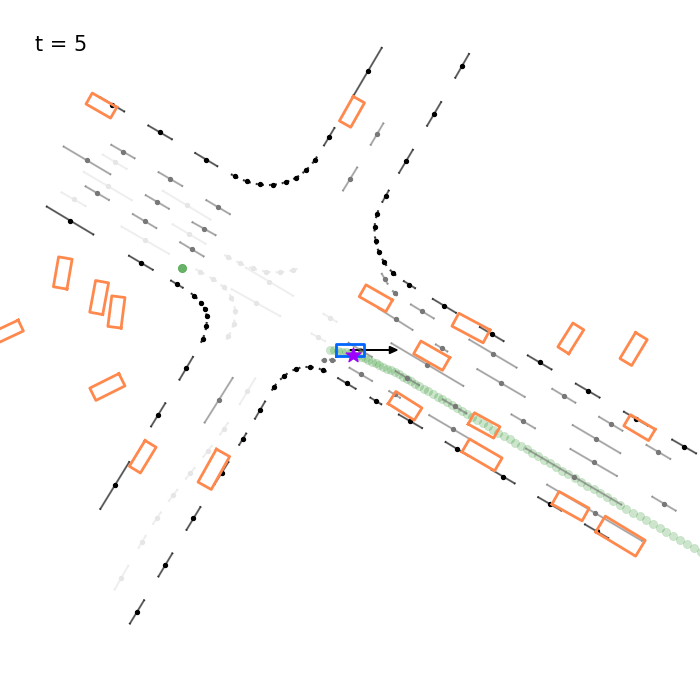

In [7]:
traj_masked = env.reference_path[2, :, :]

agent_obs_masked = env.vis.plot_agent_observation(
    env_idx=env_i,
    agent_idx=agent_j,
    figsize=(7, 7),
    trajectory=traj_masked,
)

Image.fromarray(img_from_fig(agent_obs_masked))

In [17]:
traj_masked

tensor([[-2.8176e+00,  1.6540e-06,  0.0000e+00],
        [-2.2567e+00, -5.4991e-02,  0.0000e+00],
        [-1.6712e+00, -1.1899e-01,  0.0000e+00],
        [-1.1435e+00, -2.1718e-01,  0.0000e+00],
        [-5.8799e-01, -3.4425e-01,  0.0000e+00],
        [-4.9307e-02, -4.9633e-01,  0.0000e+00],
        [ 4.9877e-01, -6.5314e-01,  1.0000e+00],
        [ 1.0278e+00, -8.2594e-01,  0.0000e+00],
        [ 1.5701e+00, -1.0161e+00,  0.0000e+00],
        [ 2.0863e+00, -1.2118e+00,  0.0000e+00],
        [ 2.6098e+00, -1.4267e+00,  0.0000e+00],
        [ 3.1191e+00, -1.6454e+00,  0.0000e+00],
        [ 3.6540e+00, -1.8755e+00,  0.0000e+00],
        [ 4.1953e+00, -2.1215e+00,  0.0000e+00],
        [ 4.7675e+00, -2.3735e+00,  0.0000e+00],
        [ 5.3208e+00, -2.6513e+00,  0.0000e+00],
        [ 5.8825e+00, -2.8995e+00,  0.0000e+00],
        [ 6.4127e+00, -3.1944e+00,  0.0000e+00],
        [ 6.9735e+00, -3.4876e+00,  0.0000e+00],
        [ 7.5203e+00, -3.8051e+00,  0.0000e+00],
        [ 8.0950e+00

In [41]:
env.log_trajectory.valids.bool()[control_mask].shape

torch.Size([10, 91, 1])

In [42]:
#env.log_trajectory.pos_xy[env_i, agent_j]

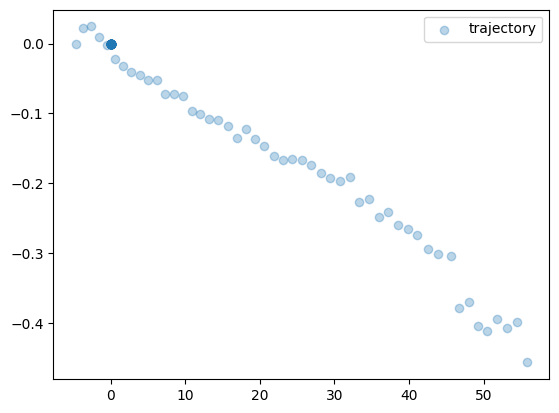

In [43]:
%matplotlib inline

#plt.scatter(traj[:, 0], traj[:, 1], label="trajectory", alpha=0.3)
plt.scatter(traj_masked[:, 0], traj_masked[:, 1], label="trajectory", alpha=0.3)
plt.legend()
plt.show()

In [34]:
# Set print options to suppress scientific notation
torch.set_printoptions(sci_mode=False)

traj_masked

tensor([[    -4.6843,     -0.0000],
        [    -3.7478,      0.0228],
        [    -2.6972,      0.0244],
        [    -1.6492,      0.0099],
        [    -0.5689,     -0.0026],
        [     0.5339,     -0.0228],
        [     1.6032,     -0.0322],
        [     2.7434,     -0.0402],
        [     3.8651,     -0.0452],
        [     5.0059,     -0.0523],
        [     6.1329,     -0.0523],
        [     7.3169,     -0.0725],
        [     8.4740,     -0.0730],
        [     9.6554,     -0.0751],
        [    10.8401,     -0.0971],
        [    12.0179,     -0.1008],
        [    13.1972,     -0.1081],
        [    14.4008,     -0.1100],
        [    15.6533,     -0.1187],
        [    16.8722,     -0.1357],
        [    18.1067,     -0.1230],
        [    19.3222,     -0.1372],
        [    20.5441,     -0.1466],
        [    21.8482,     -0.1608],
        [    23.0581,     -0.1674],
        [    24.3297,     -0.1660],
        [    25.6302,     -0.1674],
        [    26.8703,     -0

In [83]:
traj_masked.shape

torch.Size([91, 2])

### Plot agent observation with other traj

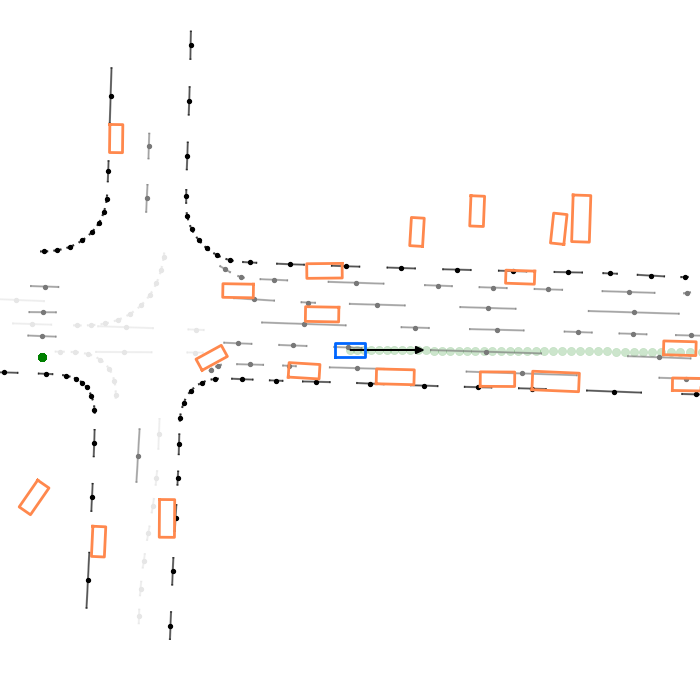

In [14]:
obs = env.reset()

traj = env.local_reference_xy[env_i, agent_j, :]

agent_obs = env.vis.plot_agent_observation(
    env_idx=env_i,
    agent_idx=agent_j,
    figsize=(7, 7),
    trajectory=traj,
)
Image.fromarray(img_from_fig(agent_obs))

In [15]:
traj.shape

torch.Size([91, 2])

In [71]:
traj_masked.shape

torch.Size([91, 2])

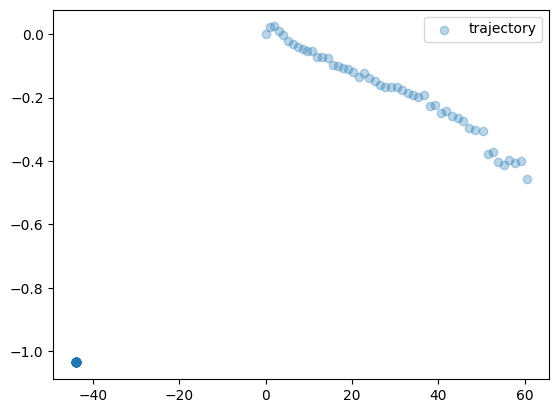

In [18]:
%matplotlib inline

plt.scatter(traj[:, 0], traj[:, 1], label="trajectory", alpha=0.3)
#plt.scatter(traj_masked[:, 0], traj_masked[:, 1], label="masked trajectory", alpha=0.3)
plt.legend()
plt.show()

In [5]:
from gpudrive.datatypes.trajectory import LogTrajectory, to_local_frame

global_ego_states = (
    env.sim.absolute_self_observation_tensor()
    .to_torch()
    .clone()
)

X_global = global_ego_states[:, :, :2]
theta_global = global_ego_states[:, :, 7]
Y_global = env.log_trajectory.pos_xy

print(f"shapes: {X_global.shape}, {theta_global.shape}, {Y_global.shape}")

shapes: torch.Size([1, 64, 2]), torch.Size([1, 64]), torch.Size([1, 64, 91, 2])


### Ground-truth

In [6]:
# 1) Translate
Y_bar = Y_global[env_i, agent_j, :] - X_global[env_i, agent_j, :]

print(Y_bar.shape)
print(Y_bar[:10])
print(" ")

# 2) Rotate
cos_yaw = torch.cos(theta_global[env_i, agent_j])
sin_yaw = torch.sin(theta_global[env_i, agent_j])
rotation_matrix = torch.tensor(
    [[cos_yaw, sin_yaw], [-sin_yaw, cos_yaw]]
)

print(f' R = {rotation_matrix.shape} =')
print(rotation_matrix)

# 3) Transform
Y_local = torch.matmul(Y_bar, rotation_matrix.T)

print(" ")
print(f' Y_local = {Y_local.shape} =')
print(
    Y_local[:5]
)

torch.Size([91, 2])
tensor([[ 0.0000,  0.0000],
        [-0.2891,  0.1440],
        [-0.6191,  0.2827],
        [-0.9414,  0.4409],
        [-1.3057,  0.6079],
        [-1.6631,  0.7720],
        [-2.0215,  0.9507],
        [-2.4121,  1.1333],
        [-2.8125,  1.3320],
        [-3.2266,  1.5381]])
 
 R = torch.Size([2, 2]) =
tensor([[-0.9079,  0.4191],
        [-0.4191, -0.9079]])
 
 Y_local = torch.Size([91, 2]) =
tensor([[ 0.0000,  0.0000],
        [ 0.3228, -0.0096],
        [ 0.6806,  0.0028],
        [ 1.0395, -0.0057],
        [ 1.4402, -0.0047]])


### Batched

In [7]:
# 1) Translate
Y_bar_batched = Y_global[env_i] - X_global[env_i].unsqueeze(1)

print(Y_bar.shape)
print(Y_bar[agent_j, :10])

# 2) Rotate
cos_yaw = torch.cos(theta_global[env_i])
sin_yaw = torch.sin(theta_global[env_i])
R_batched = torch.stack(
    [
        torch.stack([cos_yaw, sin_yaw], dim=1),
        torch.stack([-sin_yaw, cos_yaw], dim=1),
    ],
    dim=1,
) 

print(f' ')
print(f' R = {R_batched.shape} =')
print(R_batched[agent_j, :, :])

# 3) Transform
Y_local_batched = torch.bmm(
    Y_bar_batched, R_batched.transpose(1, 2)
)

print(" ")
print(f' Y_local = {Y_local_batched.shape} =')
print(
    Y_local_batched[agent_j, :10]
)

torch.Size([91, 2])
tensor([-1.3057,  0.6079])
 
 R = torch.Size([64, 2, 2]) =
tensor([[-0.9079,  0.4191],
        [-0.4191, -0.9079]])
 
 Y_local = torch.Size([64, 91, 2]) =
tensor([[ 0.0000e+00,  0.0000e+00],
        [ 3.2282e-01, -9.6245e-03],
        [ 6.8063e-01,  2.8185e-03],
        [ 1.0395e+00, -5.7459e-03],
        [ 1.4402e+00, -4.6898e-03],
        [ 1.8335e+00, -3.8388e-03],
        [ 2.2338e+00, -1.5878e-02],
        [ 2.6650e+00, -1.7957e-02],
        [ 3.1118e+00, -3.0572e-02],
        [ 3.5741e+00, -4.4107e-02]])


In [8]:
torch.equal(
    Y_local_batched[agent_j, :], Y_local[:]
)

True

In [9]:
agent_obs = env.vis.plot_agent_observation(
    env_idx=env_idx,
    agent_idx=highlight_agent,
    figsize=(10, 10),
    trajectory=Y_local,
)

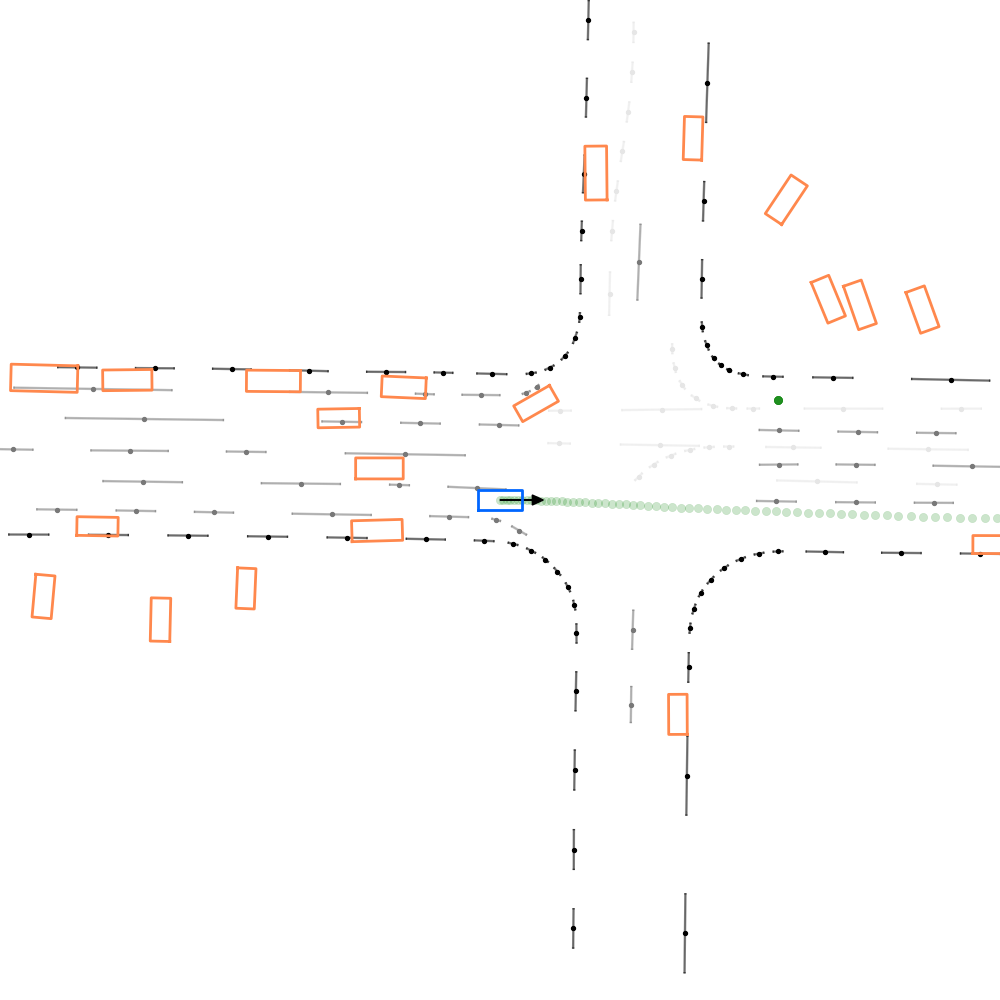

In [10]:
Image.fromarray(img_from_fig(agent_obs))

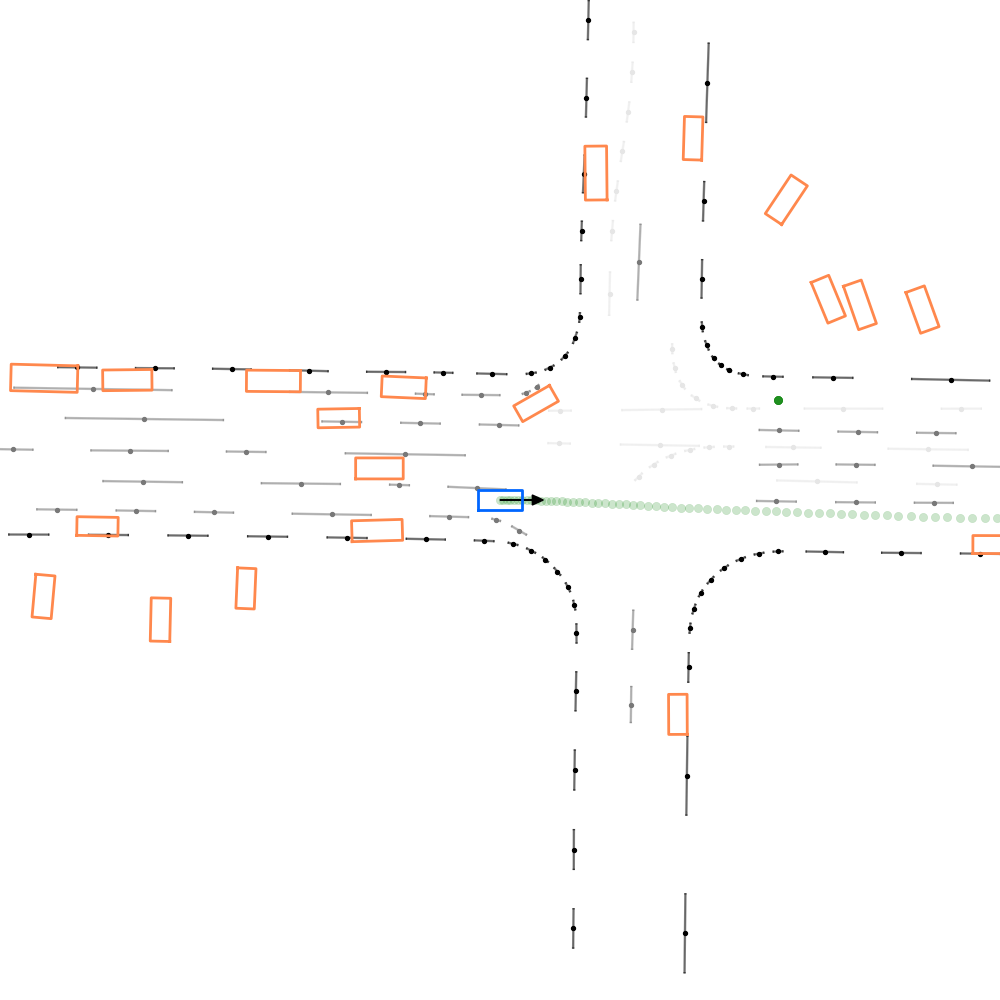

In [11]:
agent_obs = env.vis.plot_agent_observation(
    env_idx=env_idx,
    agent_idx=highlight_agent,
    figsize=(10, 10),
    trajectory=Y_local_batched[agent_j, :]
)

Image.fromarray(img_from_fig(agent_obs))